In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

In [2]:
# Загрузим игрушечный датасет из sklearn
iris = datasets.load_iris()
X = iris.data
X.shape

(150, 4)

In [3]:
# Для начала отмасштабируем выборку
X_ = X.astype(float)

rows, cols = X_.shape

# центрирование - вычитание из каждого значения среднего по строке
means = X_.mean(0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]

# деление каждого значения на стандартное отклонение
std = np.std(X_, axis=0)
for i in range(cols):
    for j in range(rows):
        X_[j][i] /= std[i]

In [4]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X_.T.dot(X_)

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения в порядке убывания:')
for i in eig_pairs:
    print(i[0])

Собственные значения в порядке убывания:
437.77467247979916
137.1045707202104
22.01353133569721
3.1072254642928634


In [5]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описвыаемая каждой из компонент \n{var_exp}')

# а теперя оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описвыаемая каждой из компонент 
[72.96244541329992, 22.85076178670175, 3.668921889282871, 0.5178709107154776]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


In [6]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


In [7]:
# Сформируем новую матрицу "объекты-признаки"
Z = X_.dot(W)

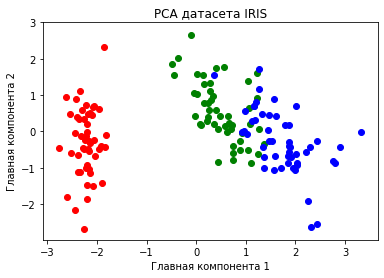

In [8]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y==i, 0], Z[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

Можно ли отобрать наиболее значимые признаки с помощью PCA?

Нет.
PCA уменьшает размерность пространства путём ингулярного разложения матрицы.

3*. Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd()

In [9]:
def pca_svd(X, n):
    
    U, s, W = np.linalg.svd(X)
    
    W_T = W.T
    
    Sigma = np.zeros_like(X, dtype=float)
    Sigma[np.diag_indices(min(X.shape))] = s
    
    Sigma = Sigma[:, :n]
    V = W_T[:, :n]
    B = U @ (Sigma @ V.T)
    
    U, s, W = np.linalg.svd(B)
    return (W @ B.T)[:n].T

In [10]:
result = pca_svd(X_, 2)

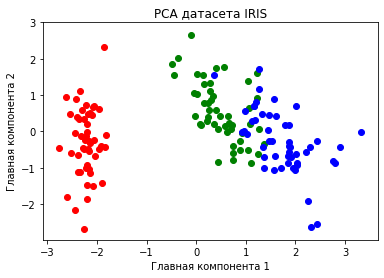

In [11]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(result[y==i, 0], result[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

4*. Обучить любую модель классификации на датасете iris до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

In [12]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    cmap = ListedColormap(['red', 'green', 'blue'])
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [19]:
from sklearn import model_selection
from sklearn.datasets import load_iris
from matplotlib.colors import ListedColormap

X, y = load_iris(return_X_y=True)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.35, random_state=42)

Точность алгоритма при k = 3: 0.981


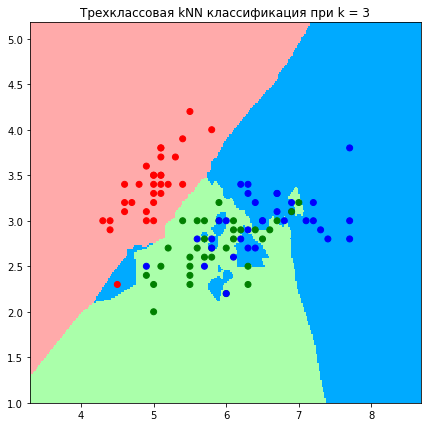

In [20]:
k = 3

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

get_graph(X_train, y_train, k)

In [21]:
X_pca = pca_svd(X, 2)

In [22]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_pca, y, test_size=0.35, random_state=42)

Точность алгоритма при k = 3: 1.000


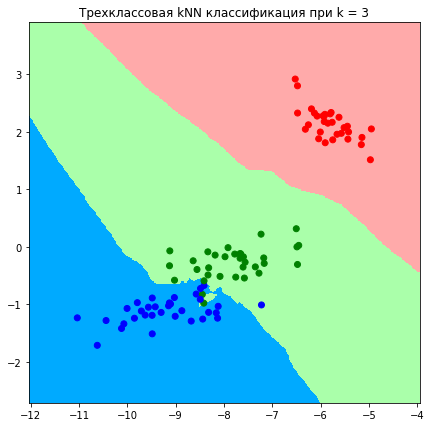

In [23]:
k = 3

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

get_graph(X_train, y_train, k)